In [33]:
import numpy as np
from c_lang_integers import CUInt, UInt8, UInt16, UInt32

# Modeling

We want to steer a linear motion of a camera by mobile phone or computer.
The overall system consists of an Arduino UNO, a stepper motor with driver and a linear guide with thread drive.

![Model Overview](modeling.svg)

(Those components are chosen because I had them lying around, not because they are the best fit.)

We roll up the system from its end, the camera mount.
The screw drive is moving the camera mount and the rotation of the screw drive is driven by the stepper motor.
We assume 3 mm of linear  movement per revolution.
The stepper motor needs 200 steps per revolution, and the stepper motor in use breaks this down into even more micro steps, so we end up with 1600 steps per revolution.
We summarize those relationships in the formula 

$x = m \cdot n$.

The variable $x$ is the position, $m$ denotes the overall transmission ratio and $n$ is the number of steps done.
The number of steps is prescribed by our microcontroller (Arduino, ATMEGA 328P).
Besides the number, we can control the frequency $f_\mathrm{stepper}$ of the steps, which prescribes the velocity $v$ of the linear movement.
Dividing the previous formula by the time interval $\Delta t$ the stepper needed to do $n$ steps, moving the camera mount by distance $x$, we get

$v = m \cdot f_\mathrm{stepper}$.

The microcontroller has to generate pulses with a constant frequency.

![Constant Frequency Pulses](constant_pulses.svg)

The signal can be generated with the timer peripheral and in principal we are done.
We use CDT mode with one timer to generate the rate and another timer to determine the pulse length.
With regards to the rate we introduce the number of timer cycles $k$, which is used as OCR value for the rate 
generation and can be calculated with

$k = f_\mathrm{timer} / f_\mathrm{stepper}$

Here the clock frequency $f_\mathrm{timer}$ of the timer peripheral is used.

However, with this solution, we are limited to a fixed velocity and this fixed velocity has to be rather slow.
Otherwise, the motor might loose steps at start or does not run at all.

To overcome these limitations, we introduce a trapezodial velocity profile, defined by the acceleration $a$.

![A trapezodial velocity profile](trapezodial_velocity_profile.svg)

Subsequently, we can not use a fixed timer configuration anymore, but have to adapt the configuration between each step during acceleration and deacceleration.
Acceleration and deacceleration are more or less equal, we assess the acceleration only.
Here we calculate the velocity with

$v = a_\mathrm{a} \cdot \left( t - t_0 \right)$.

With the constant $a_\mathrm{a}$, we get the linear behavior over time $t$.
We have to calculate $k$ and adapt it regularly, to mimic this behavior with our timer peripheral.
$k$ can be calculated, using

$k(t) = \frac{f_\mathrm{timer}}{f_\mathrm{stepper}} = \frac{f_\mathrm{timer} \cdot m}{a \cdot (t - t_0)}$.

Each step, takes a certain period of time.
Therefore $k(t)$ has to be evaluated only at certain points in time.
Eventually, we get a sequence $k_i$ instead of a function.
With the sequence, $t$ becomes $t_i$ which can be determined with

$t_i = \frac{\sum_{j=0}^{i-1} k_i}{f_\mathrm{timer}}$

This is a division of pretty big numbers, and keeps the microcontroller busy for some time.
To circumvent compute time bottlenecks, we transform this problem into another counter.
The value $k$ is correlated to the time a step takes ($\Delta t = k / f_\mathrm{timer}$) and to the velocity (see above).
So, we can determine the number of stepper steps, the system can make for each value of $k$ before it has to adapt $k$ to maintain the acceleration.
We call this value $k_\mathrm{sumlim}(k)$ and it is determined by

$k_\mathrm{sumlim}(k) = \frac{f_\mathrm{timer} \cdot m}{a} \left( \frac{1}{k_i} - \frac{1}{k_i-1}\right) $

Now, all we have to to, is starting with some value of $k$, for example $k = 255$, repeat steps with this value until we reached $k_\mathrm{sumlim}(k=255)$ and then decrement $k$ by one and do the same with the next value.
Given $k$ is bigger than $k_\mathrm{sumlim}(k)$ we skip $k$ 's until we consumed the sum of the $k_\mathrm{sumlim}$ 's is equal $k$.

## Parameters

In [34]:
# Transmission ratio m
m = 3 / 1600

# acceleration and deacceleration set point
a = 30

# velocity set point
v_set = 10

# position set point
x_set = 15

# clock frequency (atmega)
f_clk = 16e6

# counter with (8bit)
n_cnt = 255

# timer prescaler
prescaler = 256

# timer frequency
f_timer = f_clk / prescaler

## Prescale options

In [35]:
prescale_values = [1, 8, 32, 64, 128, 256, 1024]

f_timer_arr = f_clk / np.array(prescale_values)

min_velocities = f_timer_arr / 255 * m
max_velocities = f_timer_arr / 2 * m

np.vstack((prescale_values, min_velocities, max_velocities)).T

array([[1.00000000e+00, 1.17647059e+02, 1.50000000e+04],
       [8.00000000e+00, 1.47058824e+01, 1.87500000e+03],
       [3.20000000e+01, 3.67647059e+00, 4.68750000e+02],
       [6.40000000e+01, 1.83823529e+00, 2.34375000e+02],
       [1.28000000e+02, 9.19117647e-01, 1.17187500e+02],
       [2.56000000e+02, 4.59558824e-01, 5.85937500e+01],
       [1.02400000e+03, 1.14889706e-01, 1.46484375e+01]])

## Precalculated Steps

In [36]:
Dks = {n: round(m * f_timer**2 / a  * (1/(n-1) - 1/n)) for n in range(255, 2, -1)}

## Movement Planning

### Acceleration phase

In [48]:
m * f_timer / v_set

11.71875

In [49]:
v_set

10

In [37]:
k = UInt8(255)
Dk = UInt16(Dks[k.value])
p = UInt8(0)
pk = UInt16(0)

movement_plan = [
    [k.value, 1]
]

# 
f_clk100 = UInt16(int(f_clk / 100))

k_target = round(m * f_timer / v_set)

assert k_target in Dks.keys()

while k.value > k_target and p.value < x_set:

    if Dk.value > k.value:
        Dk -= k
    else:
        r = UInt16(k.value) - Dk
        k -= 1
        
        while r.value > Dks[k.value]:
            r -= Dks[k.value]
            k -= 1

        Dk = UInt16(Dks[k.value]) - r

    if k.value == movement_plan[-1][0] and movement_plan[-1][1] < 255:
        movement_plan[-1][1] += 1
    else:
        movement_plan.append([k.value, 1])

    pk += 1

    if (pk.value > 533):
        pk = UInt16(0)
        p += 1

p_acc = CUInt(p)
pk_acc = CUInt(pk)

In [38]:
len(movement_plan), p_acc, pk_acc

(81, CInt(1,1), CInt(287,2))

### Steady Phase

In [39]:
533 - 287

246

In [40]:
steady_target = (x_set - p_acc.value - 1, 533 - pk_acc.value)
steady_target

(13, 246)

In [41]:
while p.value < steady_target[0] or (p.value == steady_target[0] and pk.value < steady_target[1]):

    if k_target == movement_plan[-1][0] and movement_plan[-1][1] < 255:
        movement_plan[-1][1] += 1
    else:
        movement_plan.append([k_target, 1])

    pk += 1

    if (pk.value > 533):
        pk = UInt16(0)
        p += 1


In [42]:
len(movement_plan)

105

In [43]:
p, pk, p_acc, pk_acc

(CInt(13,1), CInt(246,2), CInt(1,1), CInt(287,2))

### Deacceleration

In [13]:
r, k

(CInt(1,2), CInt(12,1))

In [44]:

Dk = r

while p.value < x_set:

    if Dk.value > k.value:
        Dk -= k
    else:
        r = UInt16(k.value) - Dk
        k += 1
        
        while r.value > Dks[k.value] and k.value <= 254:
            r -= Dks[k.value]
            k += 1

        Dk = UInt16(Dks[k.value]) - r

    print(k.value, Dk.value)

    if k.value == movement_plan[-1][0] and movement_plan[-1][1] < 255:
        movement_plan[-1][1] += 1
    else:
        print(movement_plan[-1])
        movement_plan.append([k.value, 1])

    pk += 1

    if (pk.value > 533):
        pk = UInt16(0)
        p += 1

13 1554
[12, 248]
13 1541
13 1528
13 1515
13 1502
13 1489
13 1476
13 1463
13 1450
13 1437
13 1424
13 1411
13 1398
13 1385
13 1372
13 1359
13 1346
13 1333
13 1320
13 1307
13 1294
13 1281
13 1268
13 1255
13 1242
13 1229
13 1216
13 1203
13 1190
13 1177
13 1164
13 1151
13 1138
13 1125
13 1112
13 1099
13 1086
13 1073
13 1060
13 1047
13 1034
13 1021
13 1008
13 995
13 982
13 969
13 956
13 943
13 930
13 917
13 904
13 891
13 878
13 865
13 852
13 839
13 826
13 813
13 800
13 787
13 774
13 761
13 748
13 735
13 722
13 709
13 696
13 683
13 670
13 657
13 644
13 631
13 618
13 605
13 592
13 579
13 566
13 553
13 540
13 527
13 514
13 501
13 488
13 475
13 462
13 449
13 436
13 423
13 410
13 397
13 384
13 371
13 358
13 345
13 332
13 319
13 306
13 293
13 280
13 267
13 254
13 241
13 228
13 215
13 202
13 189
13 176
13 163
13 150
13 137
13 124
13 111
13 98
13 85
13 72
13 59
13 46
13 33
13 20
13 7
14 1335
[13, 120]
14 1321
14 1307
14 1293
14 1279
14 1265
14 1251
14 1237
14 1223
14 1209
14 1195
14 1181
14 1167
14

## Display Movement

In [47]:
k_target

12

In [45]:
movement_plan

[[255, 1],
 [202, 1],
 [173, 1],
 [154, 1],
 [141, 1],
 [130, 1],
 [122, 1],
 [115, 1],
 [109, 1],
 [104, 1],
 [100, 1],
 [96, 1],
 [92, 1],
 [89, 1],
 [87, 1],
 [84, 1],
 [82, 1],
 [79, 1],
 [78, 1],
 [76, 1],
 [74, 1],
 [72, 1],
 [71, 1],
 [69, 1],
 [68, 1],
 [67, 1],
 [66, 1],
 [65, 1],
 [64, 1],
 [63, 1],
 [62, 1],
 [61, 1],
 [60, 1],
 [59, 1],
 [58, 1],
 [57, 2],
 [56, 1],
 [55, 1],
 [54, 2],
 [53, 2],
 [52, 1],
 [51, 2],
 [50, 2],
 [49, 2],
 [48, 3],
 [47, 2],
 [46, 3],
 [45, 2],
 [44, 3],
 [43, 3],
 [42, 4],
 [41, 3],
 [40, 4],
 [39, 4],
 [38, 5],
 [37, 5],
 [36, 5],
 [35, 6],
 [34, 7],
 [33, 7],
 [32, 7],
 [31, 9],
 [30, 9],
 [29, 10],
 [28, 12],
 [27, 13],
 [26, 14],
 [25, 17],
 [24, 18],
 [23, 21],
 [22, 24],
 [21, 27],
 [20, 33],
 [19, 37],
 [18, 44],
 [17, 53],
 [16, 64],
 [15, 77],
 [14, 96],
 [13, 120],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [12, 255],
 [1

In [15]:
steps = sum([cnt*[n] for n, cnt in movement_plan], [])

In [16]:
len(steps)

8011

In [17]:
t_s = []
v_s = []
x_s = []

x = 0
t = 0

for n in steps:
    T = n / f_timer
    t += T
    x += m

    t_s.append(t)
    v_s.append(m/T)
    x_s.append(x)

In [18]:
from matplotlib import pyplot as plt

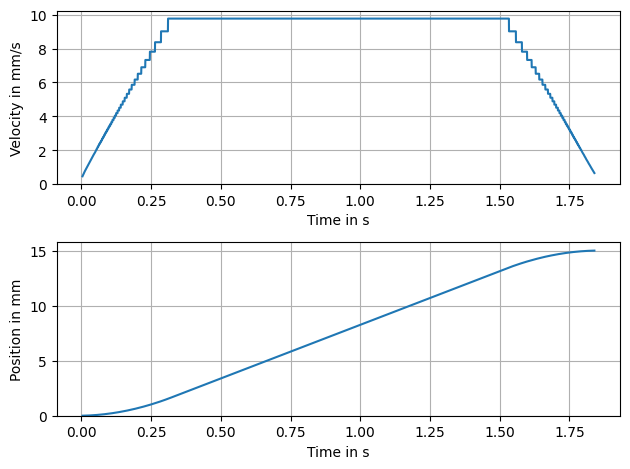

In [19]:
fig, [ax1, ax2] =  plt.subplots(2,1)

ax1.plot(t_s, v_s)

ax1.set_ylim((0,None))

ax1.set_xlabel("Time in s")
ax1.set_ylabel("Velocity in mm/s")
ax1.grid()

ax2.plot(t_s, x_s)

ax2.set_ylim((0,None))

ax2.set_xlabel("Time in s")
ax2.set_ylabel("Position in mm")
ax2.grid()

plt.tight_layout()

## C Code Generation

### Movment Plan

For testing purposes

In [20]:
template = """
static constexpr Block expected_movement_plan[] = {{
\t{}
}};
"""

generated_code = template.format(
    ", ".join([f"{{{k}, {n}}}" for k, n in movement_plan])
)

print(generated_code)


static constexpr Block expected_movement_plan[] = {
	{255, 1}, {202, 1}, {173, 1}, {154, 1}, {141, 1}, {130, 1}, {122, 1}, {115, 1}, {109, 1}, {104, 1}, {100, 1}, {96, 1}, {92, 1}, {89, 1}, {87, 1}, {84, 1}, {82, 1}, {79, 1}, {78, 1}, {76, 1}, {74, 1}, {72, 1}, {71, 1}, {69, 1}, {68, 1}, {67, 1}, {66, 1}, {65, 1}, {64, 1}, {63, 1}, {62, 1}, {61, 1}, {60, 1}, {59, 1}, {58, 1}, {57, 2}, {56, 1}, {55, 1}, {54, 2}, {53, 2}, {52, 1}, {51, 2}, {50, 2}, {49, 2}, {48, 3}, {47, 2}, {46, 3}, {45, 2}, {44, 3}, {43, 3}, {42, 4}, {41, 3}, {40, 4}, {39, 4}, {38, 5}, {37, 5}, {36, 5}, {35, 6}, {34, 7}, {33, 7}, {32, 7}, {31, 9}, {30, 9}, {29, 10}, {28, 12}, {27, 13}, {26, 14}, {25, 17}, {24, 18}, {23, 21}, {22, 24}, {21, 27}, {20, 33}, {19, 37}, {18, 44}, {17, 53}, {16, 64}, {15, 77}, {14, 96}, {13, 120}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255}, {12, 255},

### Precalculated cycle update steps

In [ ]:
template = """
static constexpr uint16_t calculate_cycleupdate_steps[256] = {{
\t{}
}};

static_assert(calculate_cycleupdate_steps[3] == 40690);
static_assert(calculate_cycleupdate_steps[7] == 5813);
static_assert(calculate_cycleupdate_steps[233] == 5);
static_assert(calculate_cycleupdate_steps[234] == 4);
"""

generated_code = template.format(
    ", ".join([f"{Dks.get(i, 0)}" for i in range(0,256)])
)

print(generated_code)


static constexpr uint16_t calculate_cycleupdate_steps[] = {
	0, 0, 0, 40690, 20345, 12207, 8138, 5813, 4360, 3391, 2713, 2219, 1850, 1565, 1341, 1163, 1017, 898, 798, 714, 642, 581, 528, 482, 442, 407, 376, 348, 323, 301, 281, 263, 246, 231, 218, 205, 194, 183, 174, 165, 157, 149, 142, 135, 129, 123, 118, 113, 108, 104, 100, 96, 92, 89, 85, 82, 79, 76, 74, 71, 69, 67, 65, 63, 61, 59, 57, 55, 54, 52, 51, 49, 48, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 33, 32, 31, 30, 30, 29, 29, 28, 27, 27, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 22, 21, 21, 20, 20, 20, 19, 19, 19, 18, 18, 18, 17, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 15, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4

In [ ]:
Dks[3]

40690